In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data
from nn_modules import View


In [2]:
torch.__version__

'0.4.1'

In [3]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


5


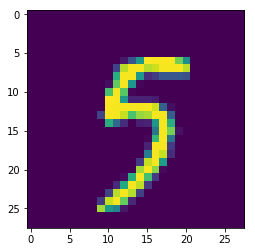

In [4]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet with disjoint trainset and testset

In [5]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

in_channels = train_input.shape[1]
out_channels = 10

LeNet_gen = lambda : nn.Sequential(
        nn.Conv2d(in_channels, 6, kernel_size=(5, 5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(6, 16, kernel_size=(5,5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        View([-1]),

        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(84, out_channels),
        nn.Sigmoid()
    )

In [211]:
#debug_layers_dims(LeNet_gen(), train_input.shape)

In [212]:
target_classes = np.array(train_target.tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 97, 1: 116, 2: 99, 3: 93, 4: 105, 5: 92, 6: 94, 7: 117, 8: 87, 9: 100}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00230           0.124         0.00229           0.214
10                      0.00183           0.590         0.00173           0.726
20                      0.00166           0.757         0.00160           0.807
30                      0.00159           0.831         0.00158           0.827
40                      0.00156           0.875         0.00156           0.861
50                      0.00154           0.899         0.00155           0.883
60                      0.00153           0.918         0.00154           0.890
70                      0.00151           0.945         0.00153           0.910
80                      0.00151           0.949         0.00153           0.918
90                      0.00150           0.958         0.00153           0.915
100                     0.00149         

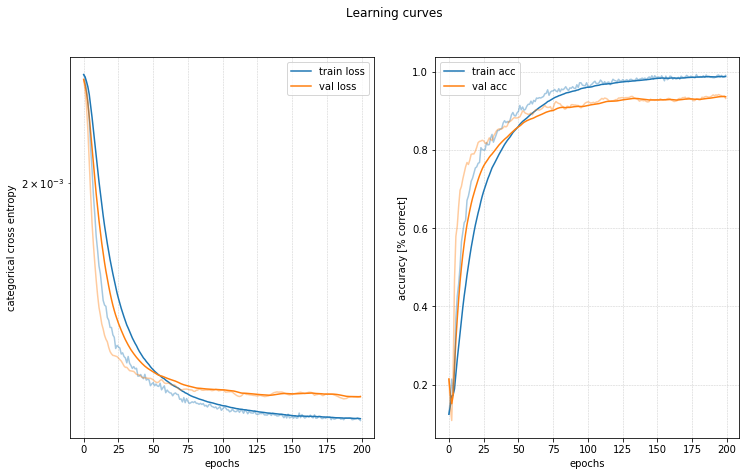

In [215]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.005

mt = ModelTrainer(LeNet, loss_fun, optim.Adam(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=200, batch_size=None, verbose=10)
mt.plot_training("Learning curves")

In [234]:
LeNet.eval()
i = 36
print(LeNet(test_input[i].reshape(-1, 1, 28, 28)).argmax(1))
test_target[i]

tensor([2])


tensor(7)

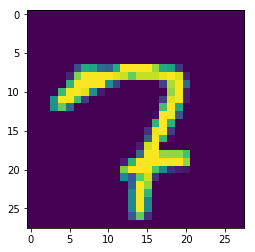

In [231]:
plt.imshow(test_input[36, 0])

## 2) Testing with a fraction of data from trainset (10%)

In [6]:
test_input.shape

torch.Size([1000, 1, 28, 28])

In [7]:
def generate_biasedset(train_dataset, test_dataset, bias=0.1, plot=False):
    train_input = train_dataset[0]
    train_target = train_dataset[1]
    test_input = test_dataset[0]
    test_target = test_dataset[1]
    
    biased_input = test_input.clone()
    biased_target = test_target.clone()

    N = len(train_input)
    indices_add = np.random.choice(np.arange(0, N), int(bias * N))

    M = len(test_input)
    indices_replace = np.random.choice(np.arange(0, M), int(bias * M))

    for i in range(len(indices_add)):
        biased_input[indices_replace[i]] = train_input[indices_add[i]]
        biased_target[indices_replace[i]] = train_target[indices_add[i]]
        
    if plot:
        plt.subplot(121)
        plt.imshow(biased_input[indices_replace[0]][0])
        plt.subplot(122)
        plt.imshow(test_input[indices_replace[0]][0])

    return (biased_input, biased_target)

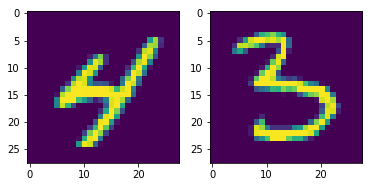

In [8]:
biased_dataset = generate_biasedset(train_dataset, test_dataset, plot=True)

In [9]:
target_classes = np.array(biased_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 89, 1: 119, 2: 111, 3: 100, 4: 112, 5: 88, 6: 90, 7: 107, 8: 87, 9: 97}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00230           0.109         0.00229           0.170
10                      0.00188           0.532         0.00179           0.684
20                      0.00167           0.750         0.00164           0.798
30                      0.00161           0.829         0.00158           0.849
40                      0.00156           0.871         0.00156           0.877
50                      0.00154           0.918         0.00153           0.911
60                      0.00152           0.946         0.00152           0.922
70                      0.00151           0.949         0.00151           0.929
80                      0.00150           0.961         0.00151           0.941
90                      0.00149           0.971         0.00151           0.934
100                     0.00149         

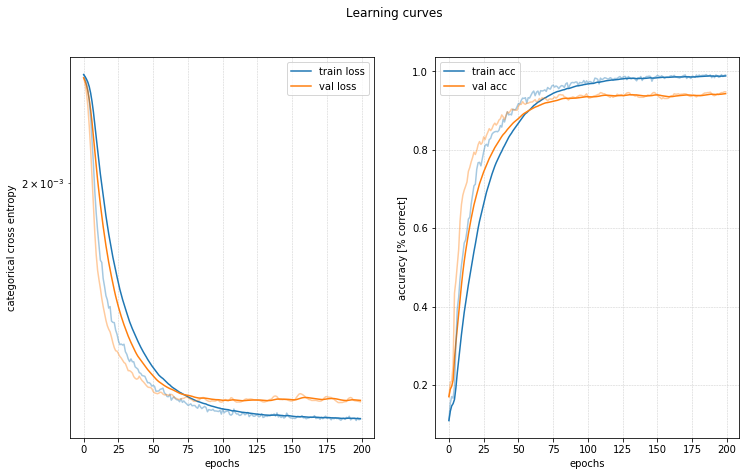

In [10]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.005

mt = ModelTrainer(LeNet, loss_fun, optim.Adam(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, biased_dataset, epochs=200, batch_size=None, verbose=10)
mt.plot_training("Learning curves")

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(alexnet.parameters(), lr=0.001)

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [10]:
target.reshape(-1, 1)

NameError: name 'target' is not defined

In [9]:
crit_fun = lambda input_, target : (input_, target.reshape(-1, 1))
y_hat_fun = lambda y: y.max(1)

mt = ModelTrainer(alexnet32, criterion, optimizer, y_hat_fun, crit_fun)
hist = mt.fit((train_input, train_target), (test_input, test_target), epochs=500, batch_size=250, verbose=10)
mt.plot_training("Learning curves")

RuntimeError: multi-target not supported at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/THNN/generic/ClassNLLCriterion.c:21